# Imports & Functions

In [63]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os

import random
from math import floor
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import os
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


# Data Preprocessing

Katrina Yu

In [64]:
path = "./data/"

df = pd.read_csv(path + "GOOG.csv")

print(df.shape)
print(df[0:5])

# Dropping date and Adj Close, not needed
df.drop(columns={"Date", "Adj Close"}, inplace=True)

out_close = df[["Close"]]

# Close Feature for Input
df.rename(columns={"Close": "In Close"}, inplace=True)
df = pd.concat([df, out_close], axis=1)

# Close Feature for Output
df.rename(columns={"Close": "Out Close"}, inplace=True)

print(df.shape)
print(df[0:5])

# Close Feature for Input
print("In Close:\n")
print(df[["In Close"][0:5]])

# Close Feature for Output
print("Out Close:\n")
print(df[["Out Close"][0:5]])

print(df.head())

(3578, 7)
         Date       Open       High        Low      Close  Adj Close    Volume
0  2004-08-19  49.676899  51.693783  47.669952  49.845802  49.845802  44994500
1  2004-08-20  50.178635  54.187561  49.925285  53.805050  53.805050  23005800
2  2004-08-23  55.017166  56.373344  54.172661  54.346527  54.346527  18393200
3  2004-08-24  55.260582  55.439419  51.450363  52.096165  52.096165  15361800
4  2004-08-25  52.140873  53.651051  51.604362  52.657513  52.657513   9257400
(3578, 6)
        Open       High        Low   In Close    Volume  Out Close
0  49.676899  51.693783  47.669952  49.845802  44994500  49.845802
1  50.178635  54.187561  49.925285  53.805050  23005800  53.805050
2  55.017166  56.373344  54.172661  54.346527  18393200  54.346527
3  55.260582  55.439419  51.450363  52.096165  15361800  52.096165
4  52.140873  53.651051  51.604362  52.657513   9257400  52.657513
In Close:

         In Close
0       49.845802
1       53.805050
2       54.346527
3       52.096165
4  

### Normalizing Data
Katrina Yu

In [65]:
print(df.head())

# Numeric Features
numeric_feats = ["Open", "High", "Low", "In Close", "Volume"]

# Data Normalization for Input Features, so exclude "Out Close"
for i in numeric_feats:
    encode_numeric_zscore(df, i)
    
print(df.shape)
print(df.head())

        Open       High        Low   In Close    Volume  Out Close
0  49.676899  51.693783  47.669952  49.845802  44994500  49.845802
1  50.178635  54.187561  49.925285  53.805050  23005800  53.805050
2  55.017166  56.373344  54.172661  54.346527  18393200  54.346527
3  55.260582  55.439419  51.450363  52.096165  15361800  52.096165
4  52.140873  53.651051  51.604362  52.657513   9257400  52.657513
(3578, 6)
       Open      High       Low  In Close    Volume  Out Close
0 -1.334844 -1.331443 -1.337457 -1.333645  4.533247  49.845802
1 -1.333101 -1.322843 -1.329562 -1.319893  1.870138  53.805050
2 -1.316291 -1.315305 -1.314693 -1.318012  1.311494  54.346527
3 -1.315446 -1.318526 -1.324223 -1.325828  0.944353  52.096165
4 -1.326284 -1.324693 -1.323684 -1.323879  0.205033  52.657513


### Train-Test Split for Training & Testing
Katrina Yu

In [ ]:
# Splitting 70% of data for Training & 30% for Testing
split_index = floor((df["Open"].shape[0])*0.70)

df_train = df[0:split_index]
df_test = df[split_index:]

print(df_train.shape)
print(df_test.shape)

(2504, 6)
(1074, 6)


### Sequence data to create x and y in the format RNN likes.
Katrina Yu

In [67]:
import numpy as np

def to_sequences(seq_size, data):
    x = []
    y = []

    for i in range(len(data)-seq_size-1):
        #print(i)
        window = data.iloc[i:(i+seq_size)][["Open", "High", "Low", "In Close", "Volume"]].values
        after_window = data.iloc[i+seq_size]["Out Close"]
        #window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

In [68]:
print(len(df_train))

# Past 7 days used for prediction
SEQUENCE_SIZE = 7
x_train,y_train = to_sequences(SEQUENCE_SIZE, df_train)
x_test,y_test = to_sequences(SEQUENCE_SIZE, df_test)

print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

#print("x_train:\n {}".format(x_train[0:3]))

#print("y_train:\n {}".format(y_train[0:3]))

2504
Shape of x_train: (2496, 7, 5)
Shape of x_test: (1066, 7, 5)
Shape of y_train: (2496,)
Shape of y_test: (1066,)


# Building RNN Model using LSTM
Katrina Yu

In [84]:
model_dir = "models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

for i in range(5):
    model = Sequential()
    
    model.add(LSTM(512, input_shape=(SEQUENCE_SIZE,5), activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(256))
    model.add(Dropout(0.1))
    model.add(Dense(128))
    model.add(Dense(1, activation=None))

    model.compile(loss="mean_squared_error", optimizer="adam")

    monitor = EarlyStopping(monitor="val_loss", min_delta=1e-3, patience=5, verbose=1, mode="auto")
    checkpointer = ModelCheckpoint(filepath="models/lstm_checkpoint.keras", verbose=0, save_best_only=True)

    model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=100)  
    
model.load_weights('models/lstm_checkpoint.keras')

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
79/79 - 13s - 166ms/step - loss: 49673.9961 - val_loss: 816133.3125
Epoch 2/100
79/79 - 2s - 21ms/step - loss: 5225.0581 - val_loss: 59197.8203
Epoch 3/100
79/79 - 2s - 21ms/step - loss: 1938.4595 - val_loss: 11727.3125
Epoch 4/100
79/79 - 2s - 21ms/step - loss: 548.2869 - val_loss: 2093.6519
Epoch 5/100
79/79 - 2s - 24ms/step - loss: 203.3291 - val_loss: 170.6643
Epoch 6/100
79/79 - 2s - 21ms/step - loss: 131.3463 - val_loss: 616.1205
Epoch 7/100
79/79 - 2s - 21ms/step - loss: 107.8557 - val_loss: 291.2555
Epoch 8/100
79/79 - 2s - 21ms/step - loss: 110.6601 - val_loss: 616.2076
Epoch 9/100
79/79 - 2s - 21ms/step - loss: 104.2396 - val_loss: 553.4978
Epoch 10/100
79/79 - 2s - 22ms/step - loss: 100.7090 - val_loss: 639.0256
Epoch 10: early stopping
Epoch 1/100
79/79 - 9s - 110ms/step - loss: 50755.7109 - val_loss: 482045.8750
Epoch 2/100
79/79 - 2s - 25ms/step - loss: 5488.7300 - val_loss: 57875.5859
Epoch 3/100
79/79 - 2s - 26ms/step - loss: 2386.9941 - val_loss: 17264.0000

In [85]:
pred = model.predict(x_test)

print(pred.shape, y_test.shape)

score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))
print("R2:",metrics.r2_score(y_test,pred))
print("MSE:", metrics.mean_squared_error(y_test, pred))

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
(1072, 1) (1072,)
Score (RMSE): 13.189683314016115
R2: 0.9960974001859738
MSE: 173.9677459240351


## LSTM Hyperparamter Training
Katrina Yu

#### Activations

In [86]:
for i in range(5):
    model = Sequential()
    
    model.add(LSTM(512, input_shape=(SEQUENCE_SIZE,5), activation="sigmoid"))
    model.add(Dropout(0.1))
    model.add(Dense(256))
    model.add(Dropout(0.1))
    model.add(Dense(128))
    model.add(Dense(1))

    model.compile(loss="mean_squared_error", optimizer="adam")

    monitor = EarlyStopping(monitor="val_loss", min_delta=1e-3, patience=5, verbose=0, mode="auto")
    checkpointer = ModelCheckpoint(filepath="models/lstm_checkpoint_sigmoid.keras", verbose=0, save_best_only=True)

    model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor, checkpointer], verbose=0, epochs=100)  
    
model.load_weights('models/lstm_checkpoint_sigmoid.keras')

pred = model.predict(x_test)

print(pred.shape, y_test.shape)

score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))
print("R2:",metrics.r2_score(y_test,pred))
print("MSE:", metrics.mean_squared_error(y_test, pred))

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
(1072, 1) (1072,)
Score (RMSE): 50.94914773110952
R2: 0.9417683454091268
MSE: 2595.8156545264223


In [81]:
for i in range(5):
    model = Sequential()
    
    model.add(LSTM(512, input_shape=(SEQUENCE_SIZE,5), activation="tanh"))
    model.add(Dropout(0.1))
    model.add(Dense(256))
    model.add(Dropout(0.1))
    model.add(Dense(128))
    model.add(Dense(1))

    model.compile(loss="mean_squared_error", optimizer="adam")

    monitor = EarlyStopping(monitor="val_loss", min_delta=1e-3, patience=5, verbose=0, mode="auto")
    checkpointer = ModelCheckpoint(filepath="models/lstm_checkpoint_tanh.keras", verbose=0, save_best_only=True)

    model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor, checkpointer], verbose=0, epochs=100)  
    
model.load_weights('models/lstm_checkpoint_tanh.keras')

pred = model.predict(x_test)

print(pred.shape, y_test.shape)

score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))
print("R2:",metrics.r2_score(y_test,pred))
print("MSE:", metrics.mean_squared_error(y_test, pred))

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
(1072, 1) (1072,)
Score (RMSE): 16.60608332068801
R2: 0.9938138605124938
MSE: 275.76200325363254


In [82]:
for i in range(5):
    model = Sequential()
    
    model.add(LSTM(512, input_shape=(SEQUENCE_SIZE,5), activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(256))
    model.add(Dropout(0.1))
    model.add(Dense(128))
    model.add(Dense(1))

    model.compile(loss="mean_squared_error", optimizer="adam")

    monitor = EarlyStopping(monitor="val_loss", min_delta=1e-3, patience=5, verbose=0, mode="auto")
    checkpointer = ModelCheckpoint(filepath="models/lstm_checkpoint_relu_adam.keras", verbose=0, save_best_only=True)

    model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor, checkpointer], verbose=0, epochs=100)  
    
model.load_weights('models/lstm_checkpoint_relu_adam.keras')

pred = model.predict(x_test)

print(pred.shape, y_test.shape)

score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))
print("R2:",metrics.r2_score(y_test,pred))
print("MSE:", metrics.mean_squared_error(y_test, pred))

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
(1072, 1) (1072,)
Score (RMSE): 12.990055492589367
R2: 0.9962146390656426
MSE: 168.74154170055115


#### Optimizer

In [87]:
for i in range(5):
    model = Sequential()
    
    model.add(LSTM(512, input_shape=(SEQUENCE_SIZE,5), activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(256))
    model.add(Dropout(0.1))
    model.add(Dense(128))
    model.add(Dense(1))

    model.compile(loss="mean_squared_error", optimizer="sgd")

    monitor = EarlyStopping(monitor="val_loss", min_delta=1e-3, patience=5, verbose=0, mode="auto")
    checkpointer = ModelCheckpoint(filepath="models/lstm_checkpoint_relu_sgd.keras", verbose=0, save_best_only=True)

    model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor, checkpointer], verbose=0, epochs=100)  
    
model.load_weights('models/lstm_checkpoint_relu_sgd.keras')

pred = model.predict(x_test)

print(pred.shape, y_test.shape)

score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))
print("R2:",metrics.r2_score(y_test,pred))
print("MSE:", metrics.mean_squared_error(y_test, pred))

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
(1072, 1) (1072,)
Score (RMSE): 12.908776159441324
R2: 0.9962618611972833
MSE: 166.63650193456067


# Testing best Size for the Sequence

In [75]:
import matplotlib.pyplot as plt
sequence_sizes = []
rmse_scores = []
results = []
step = 1
j = 1
checkpoint_path = "models/lstm_checkpoint.keras"
best_val_loss = float('inf')  
model_dir = "models"


while j <= 100:
    print(j)
    SEQUENCE_SIZE = j
    fileName= "models/lstm_checkpoint_" + str(j) + ".keras"
    x_train,y_train = to_sequences(SEQUENCE_SIZE, df_train)
    x_test,y_test = to_sequences(SEQUENCE_SIZE, df_test)

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
        
    model = Sequential()
    model.add(LSTM(128, input_shape=(SEQUENCE_SIZE,5), activation="relu"))
    model.add(Dense(64))
    model.add(Dense(32))
    model.add(Dense(1))

    model.compile(loss="mean_squared_error", optimizer="adam")
    monitor = EarlyStopping(monitor="val_loss", min_delta=1e-3, patience=10, verbose=1, mode="auto")
    checkpointer = ModelCheckpoint(filepath=checkpoint_path, verbose=0, save_best_only=True)
    history = model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=100)
    model.save_weights(checkpoint_path)
    model.load_weights(fileName)

    pred = model.predict(x_test)
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    sequence_sizes.append(j)
    rmse_scores.append(score)
    results.append(score)
    print("Model: " + str(j) + "\nScore (RMSE): {}".format(score))
    print("R2:",metrics.r2_score(y_test,pred))
    print("MSE:", metrics.mean_squared_error(y_test, pred))
    step = step + 1
    j = j + 1
minValue = min(results)
minIndex = results.index(minValue) + 1
print("The best number of days was: " + str(minIndex)  + "\nThe RMSE was: " + str(minValue))

1


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
79/79 - 10s - 124ms/step - loss: 80105.7109 - val_loss: 531792.3750
Epoch 2/100
79/79 - 1s - 7ms/step - loss: 32677.7617 - val_loss: 446586.7500
Epoch 3/100
79/79 - 0s - 6ms/step - loss: 7220.2920 - val_loss: 569582.0625
Epoch 4/100
79/79 - 1s - 7ms/step - loss: 4238.5024 - val_loss: 201201.6875
Epoch 5/100
79/79 - 1s - 9ms/step - loss: 2566.4189 - val_loss: 97562.4219
Epoch 6/100
79/79 - 1s - 12ms/step - loss: 1213.2651 - val_loss: 40364.7070
Epoch 7/100
79/79 - 1s - 7ms/step - loss: 380.2844 - val_loss: 24271.0449
Epoch 8/100
79/79 - 1s - 12ms/step - loss: 119.9964 - val_loss: 26996.2285
Epoch 9/100
79/79 - 1s - 10ms/step - loss: 56.0107 - val_loss: 28357.7090
Epoch 10/100
79/79 - 1s - 11ms/step - loss: 44.7872 - val_loss: 27706.2480
Epoch 11/100
79/79 - 1s - 12ms/step - loss: 41.2895 - val_loss: 27770.3262
Epoch 12/100
79/79 - 1s - 12ms/step - loss: 36.9405 - val_loss: 25424.9121
Epoch 13/100
79/79 - 1s - 11ms/step - loss: 35.3147 - val_loss: 28348.0742
Epoch 14/100
79/7

ValueError: The filename must end in `.weights.h5`. Received: filepath=models/lstm_checkpoint.keras

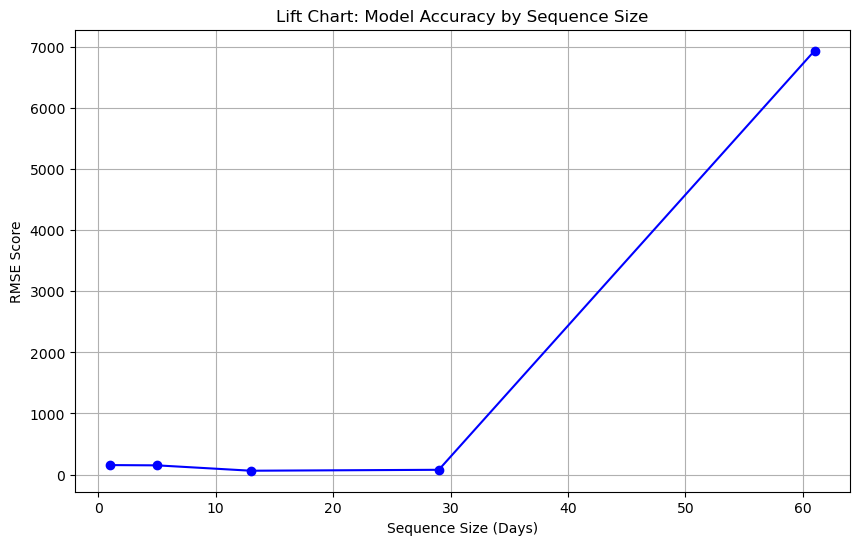

In [ ]:
best_sequence_size = sequence_sizes[minIndex]
plt.figure(figsize=(10, 6))
plt.plot(sequence_sizes, rmse_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Sequence Size (Days)')
plt.ylabel('RMSE Score')
plt.title('Lift Chart: Model Accuracy by Sequence Size')
plt.grid(True)
plt.show()